### Credenciais de Acesso Kaggle

In [ ]:
{"username":"jcss03","key":"caf02cc87bdafff295f9eb6897072757"}

{'username': 'jcss03', 'key': 'caf02cc87bdafff295f9eb6897072757'}

### Imports

In [ ]:
!pip install opendatasets
!pip install pandas

import opendatasets as od
import pandas
# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

import re

from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


### Download Dataset

In [ ]:
# download data from kaggle
od.download("https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis/download?datasetVersionNumber=2")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jcss03
Your Kaggle Key: ··········


100%|██████████| 1.99M/1.99M [00:00<00:00, 112MB/s]

In [ ]:
# caminho para o dataset
!ls ./twitter-entity-sentiment-analysis

twitter_training.csv  twitter_validation.csv


### Acesso ao Drive

In [ ]:
# Acesso a pasta do drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# exemplo
!ls /content/drive/MyDrive/'Trabalho de Graduação'/scripts

 classifier.ipynb	      model		      'scripts testes'
 data			      model_BoW-tf-idf.ipynb
 Exploratory_Analysis.ipynb   projectRoadmap


### Loading Datasets
* Train
* Test

In [ ]:
dataset_train = pd.read_csv('./twitter-entity-sentiment-analysis/twitter_training.csv',names=['Tweet_ID','entity','sentiment','Tweet content'],header=None)
dataset_validation = pd.read_csv('./twitter-entity-sentiment-analysis/twitter_validation.csv',names=['Tweet_ID','entity','sentiment','Tweet content'],header=None)

In [ ]:
print('Exemplo do dataset')
dataset_train.sample(5)

Exemplo do dataset


,Tweet_ID,entity,sentiment,Tweet content
69748,3950,Cyberpunk2077,Negative,"Dear Yeaaah, I'm not surprised from half a I'v..."
34490,6724,Fortnite,Negative,So tired of hearing about fortnite & Roblox.
13323,8687,NBA2K,Positive,RhandlerR is so fun to play with in RhandlerR!...
40845,1409,Battlefield,Negative,LEGO WWII Rotterdam Cathedral Still from
9299,9598,Overwatch,Positive,Honestly I started Zenyatta this past over in ...


#### Encodificar Targets

In [ ]:
data = dataset_train[['Tweet content','sentiment']].rename(columns={"Tweet content": "text", "sentiment": "target"})
data.target = pd.Categorical(data.target)

data['code'] = data.target.cat.codes
print('#'*100)
print(f'Targets: {data.target.unique()}')
print(f'Codes: {data.code.unique()}')
print('#'*100)
data.sample(5)

####################################################################################################
Targets: ['Positive', 'Neutral', 'Negative', 'Irrelevant']
Categories (4, object): ['Irrelevant', 'Negative', 'Neutral', 'Positive']
Codes: [3 2 1 0]
####################################################################################################


,text,target,code
73088,Nvidia keeps the site in Cambridge and expands...,Negative,1
38842,Hearthstone goes its livest and how difficult ...,Positive,3
36376,Now I think I might move it to @SonyPlay5tatio...,Negative,1
33530,"Back at the OG memes... I love the sky base, f...",Irrelevant,0
13607,A dude had talent. @t_moralde17 you blew me aw...,Irrelevant,0


#### Remover valores Null

In [ ]:
print('#'*100)
qtd_null_values = np.sum(data.isnull().any(axis=1))
print(f'Shape dos dados: {data.shape}')
print(f'Number null values = {qtd_null_values}')

# dropna values
data = data.dropna().reset_index(drop=True)

print('#'*100)
qtd_null_values = np.sum(data.isnull().any(axis=1))
print(f'Shape dos dados: {data.shape}')
print(f'Number null values = {qtd_null_values}')

####################################################################################################
Shape dos dados: (74682, 3)
Number null values = 686
####################################################################################################
Shape dos dados: (73996, 3)
Number null values = 0


### Processing Text
* stopwords
* punctuation
* Stemming(reducing the words to their derived stems)
* Lemmatization(reducing the derived words to their root form known as lemma)
* removing unnecessary characters
* lower case text to better generalization

In [ ]:
# recebe texto e processa
def processing_text(text,flag_punctuation=False,flag_stopwords=False,flag_stem=False,flag_lemma=False):

  ##############################################################################
  # funções

  # maketrans explained - 'https://www.w3schools.com/python/ref_string_maketrans.asp'
  def cleaning_punctuations(text):
      english_punctuations = string.punctuation
      punctuations_list = english_punctuations

      translator = str.maketrans('', '', punctuations_list)
      return text.translate(translator)
  
  # remover stopwords
  def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split(' ') if word not in stop_words])
    return text

  # removendo chars repetidos
  def cleaning_repeating_char(text):
      return re.sub(r'(.)1+', r'1', text)

  # removing stem
  def stemming(text):
    ps = PorterStemmer()
    text = " ".join([ps.stem(word) for word in text.split(' ')])
    return text

  def lemmatizer(text):
      lm = nltk.WordNetLemmatizer()
      text = " ".join([lm.lemmatize(word) for word in text.split(' ')])
      return text
  ##############################################################################

  # Processing

  # lower all string of text
  text = re.sub(r'[^\w\s]', '', str(text).lower().strip())

  # remover pontuações
  if flag_punctuation:
    text = cleaning_punctuations(text)

  # remover stopwords
  if flag_stopwords:
    text = remove_stopwords(text)

  # remover repetições
  text = cleaning_repeating_char(text)

  # lenma
  if flag_lemma:
    text = lemmatizer(text)

  # stem:
  if flag_stem:
    text = stemming(text)

  return text

In [ ]:
example = data.text.iloc[100]
example

'Grounded almost was pretty cool even despite the top tier unfunny writing until we became yet another annoying crafting game. I seriously can’t wait on this shitty trend to die'

In [ ]:
clean_text = processing_text(example,flag_punctuation=True,flag_stopwords=True,flag_lemma=True)
clean_text

'grounded almost pretty cool even despite top tier unfunny writing became yet another annoying crafting game seriously cant wait shitty trend die'

In [ ]:
# clean text
data['clean_text'] = data['text'].apply(lambda x: processing_text(x,flag_punctuation=True,flag_stopwords=True,flag_lemma=True))

In [ ]:
data.sample(10)

,text,target,code,clean_text
30518,made a little piece of pitch to celebrate my t...,Neutral,2,made little piece pitch celebrate team victory...
26855,7 minutes remaining until hearing the world pr...,Positive,3,7 minute remaining hearing world premiere hear...
63416,JJ Must be sooooooooooooo much lower lmfao TJ ...,Negative,1,jj must sooooooooooooo much lower lmfao tj mus...
4547,The indifferent @ Treyarch takes the damn mone...,Negative,1,indifferent treyarch take damn money cartel c...
42792,PUBG Mobile can Easily launched in INDIA by th...,Neutral,2,pubg mobile easily launched india way hindi w...
73708,I might be posting a lot of my in-game screen ...,Neutral,2,might posting lot ingame screen cap take using...
30854,im ded tired-.,Negative,1,im ded tired
28692,the,Positive,3,
14940,like this.,Positive,3,like
48765,Fuck man i cant play fifa for like 2 days alr ...,Negative,1,fuck man cant play fifa like 2 day alr stupid ...


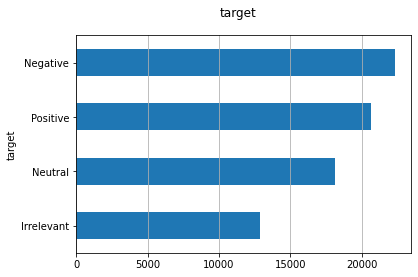

In [ ]:
fig, ax = plt.subplots()
fig.suptitle("target", fontsize=12)
data["target"].reset_index().groupby("target").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [ ]:
# data = data[data.target != 'Irrelevant']


In [ ]:
print(data.target.unique())
print(data.code.unique())


['Positive', 'Neutral', 'Negative', 'Irrelevant']
Categories (4, object): ['Irrelevant', 'Negative', 'Neutral', 'Positive']
[3 2 1 0]


### Split dataset_train 
* train
* validation

In [ ]:
from sklearn.model_selection import train_test_split

# split dataset
df_train, df_val = train_test_split(data[['code','clean_text']], test_size=0.3)
## get target
target_train = df_train["code"].values
target_val = df_val["code"].values

### Bag of Words
* classic
* tf-idf

In [ ]:
# ## Count (classic BoW)
# vectorizer = feature_extraction.text.CountVectorizer(max_features=15000, ngram_range=(1,2))

## Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=25000, ngram_range=(1,2))

In [ ]:
corpus = df_train["clean_text"]

vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [ ]:
# sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

### Classifier MultinimialNB

In [ ]:
# ok

In [ ]:
classifier = naive_bayes.MultinomialNB()

## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, target_train)
## test
X_val = df_val["clean_text"].values

predicted = model.predict(X_val)
predicted_prob = model.predict_proba(X_val)

In [ ]:
## Accuracy, Precision, Recall
from sklearn import metrics
accuracy = metrics.accuracy_score(target_val, predicted)
auc = metrics.roc_auc_score(target_val, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(target_val, predicted))
 

Accuracy: 0.71
Auc: 0.92
Detail:
              precision    recall  f1-score   support

           0       0.89      0.42      0.57      3865
           1       0.67      0.87      0.76      6732
           2       0.76      0.62      0.69      5412
           3       0.69      0.80      0.74      6190

    accuracy                           0.71     22199
   macro avg       0.75      0.68      0.69     22199
weighted avg       0.74      0.71      0.70     22199



(array([0.5, 1.5, 2.5, 3.5]), <a list of 4 Text major ticklabel objects>)

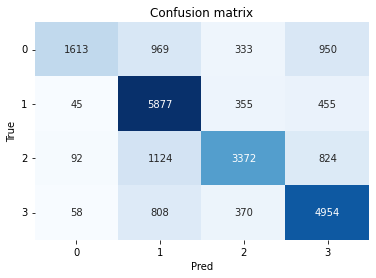

In [ ]:
## Plot confusion matrix
classes = np.unique(target_val)
cm = metrics.confusion_matrix(target_val, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

### DL

In [ ]:
features_train = df_train["clean_text"]
features_val = df_val['clean_text']

target_train = df_train["code"].values
target_val = df_val["code"].values

In [ ]:
df_train[df_train['clean_text'].str.len() == df_train['clean_text'].str.len().max()]

vocab_size = 100000 # make the top list of words (common words)
# embedding_dim = 64
# max_length = 200
max_length = int(data['clean_text'].str.len().max())
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # OOV = Out of Vocabulary



In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional



In [ ]:
train_text = df_train['clean_text']

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_text)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_text)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(df_val['clean_text'])
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

### Input

In [ ]:
print('Train padded',train_padded.shape)
print('Val padded',val_padded.shape)

print('Train labels',target_train.shape)
print('Val labels',target_val.shape)


Train padded (51797, 810)
Val padded (22199, 810)
Train labels (51797,)
Val labels (22199,)


In [ ]:
inputs_train = train_padded.reshape(train_padded.shape[0],train_padded.shape[1],1)

inputs_val = val_padded.reshape(val_padded.shape[0],val_padded.shape[1],1)

print('Train padded',inputs_train.shape)
print('Val padded',inputs_val.shape)

Train padded (51797, 810, 1)
Val padded (22199, 810, 1)


In [ ]:
input_shape = (inputs_train.shape[1],inputs_train.shape[2])

In [ ]:
model = keras.Sequential()

# model.add(tf.compat.v1.keras.layers.CuDNNLSTM(128, input_shape=input_shape,return_sequences=True))
model.add(keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(128,return_sequences=True),input_shape=input_shape))

model.add(keras.layers.Dropout(0.3))
# model.add(keras.layers.LSTM(128, input_shape=input_shape,return_sequences=True))

# model.add(keras.layers.BatchNormalization())
# model.add(keras.layers.MaxPooling1D())

model.add(keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(64)))
# model.add(keras.layers.LSTM(64))
model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.Dense(4,activation='softmax'))
# model.add(keras.layers.Dense(1,activation='sigmoid'))


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 810, 256)         134144    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 810, 256)          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              164864    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dropout_5 (Dropout)         (None, 32)               

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    loss='sparse_categorical_crossentropy',
    #loss='categorical_hinge',
    optimizer=opt,
    metrics=['accuracy']
)

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
GPU_NAME = tf.test.gpu_device_name()
print(GPU_NAME)

Num GPUs Available:  1
/device:GPU:0


In [ ]:
# epochs = 200
# batch_size = 64
# history = model.fit(inputs_train,target_train,validation_data=(inputs_val,target_val),batch_size=batch_size, epochs=epochs, verbose=1)

In [ ]:
with tf.device(GPU_NAME):
  epochs = 200
  batch_size = 64
  history = model.fit(inputs_train,target_train,validation_data=(inputs_val,target_val),batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/300
810/810 [==============================] - 133s 154ms/step - loss: 1.3486 - accuracy: 0.3320 - val_loss: 1.3381 - val_accuracy: 0.3510
Epoch 2/300
810/810 [==============================] - 121s 149ms/step - loss: 1.3383 - accuracy: 0.3487 - val_loss: 1.3430 - val_accuracy: 0.3470
Epoch 3/300
810/810 [==============================] - 121s 149ms/step - loss: 1.3340 - accuracy: 0.3533 - val_loss: 1.3280 - val_accuracy: 0.3554
Epoch 4/300
810/810 [==============================] - 120s 149ms/step - loss: 1.3315 - accuracy: 0.3577 - val_loss: 1.3315 - val_accuracy: 0.3623
Epoch 5/300
810/810 [==============================] - 120s 149ms/step - loss: 1.3288 - accuracy: 0.3607 - val_loss: 1.3315 - val_accuracy: 0.3577
Epoch 6/300
810/810 [==============================] - 119s 147ms/step - loss: 1.3254 - accuracy: 0.3637 - val_loss: 1.3372 - val_accuracy: 0.3615
Epoch 7/300
810/810 [==============================] - 120s 148ms/step - loss: 1.3230 - accuracy: 0.3677 - val_loss: 1

### Graficos 
* Train
* Validation

In [ ]:
import matplotlib as m
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 50,25


plt.suptitle('Metricas do Modelo')

plt.subplot(3,2,1)
plt.plot(history.history['loss'],label='train_Loss',color = 'Blue')
plt.plot(history.history['val_loss'],label='val_loss',color = 'red')
plt.legend(loc='best')

plt.subplot(3,2,2)
plt.plot(history.history['accuracy'],label='train_accuracy',color = 'Blue')
plt.plot(history.history['val_accuracy'],label='val_accuracy',color = 'red')
plt.legend(loc='best')

plt.show()